In [1]:
import torch
import numpy as np
from collections import deque
from mddpg import MultiAgent
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from unityagents import UnityEnvironment
env = UnityEnvironment(file_name='/data/Tennis_Linux_NoVis/Tennis')
#env = UnityEnvironment(file_name='Tennis/Tennis.exe')

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Episode 3	Average Score: 0.639
Environment solved in 3 episodes!	Average Score: 0.63


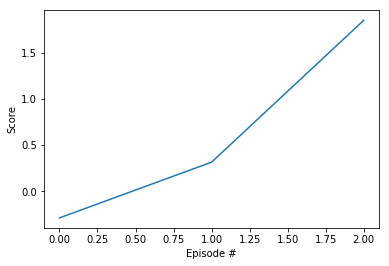

In [4]:
def ddpg(n_episodes=30000, max_t=2000):
    
    env_info = env.reset(train_mode=True)[brain_name]
    
    action_size = brain.vector_action_space_size
    state_size = env_info.vector_observations.shape[1]
    num_agents = len(env_info.agents)

    ma = MultiAgent(state_size, action_size, num_agents=num_agents, random_seed=0) # 5e-4 critic

    
    all_scores = []
    scores_window = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):
        
        ma.reset_all()
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations           
        scores = np.zeros(num_agents)

        for i in range(max_t):
            actions = ma.act_all(states)
            env_info = env.step(actions)[brain_name]
            rewards = env_info.rewards
            next_states = env_info.vector_observations
            dones = env_info.local_done

            ma.step_all(states, actions, rewards, next_states, dones)

            scores += rewards
            states = next_states
                
        avg_score = np.mean(scores)
        scores_window.append(avg_score)
        all_scores.append(avg_score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            ma.save_weights_all()
            break 
            
    return all_scores

scores = ddpg()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
def ddpg_eval(n_episodes=30000, max_t=2000):
    
    env_info = env.reset(train_mode=False)[brain_name]
    
    action_size = brain.vector_action_space_size
    state_size = env_info.vector_observations.shape[1]
    num_agents = len(env_info.agents)

    ma = MultiAgent(state_size, action_size, num_agents=num_agents, random_seed=0) # 5e-4 critic

    ma.agents[0].actor_local.load_state_dict(torch.load('agent1_checkpoint_actor.pth', map_location='cpu'))
    ma.agents[0].critic_local.load_state_dict(torch.load('agent1_checkpoint_critic.pth', map_location='cpu'))
    ma.agents[1].actor_local.load_state_dict(torch.load('agent2_checkpoint_actor.pth', map_location='cpu'))
    ma.agents[1].critic_local.load_state_dict(torch.load('agent2_checkpoint_critic.pth', map_location='cpu'))

    for i_episode in range(1, n_episodes+1):
        
        ma.reset_all()
        
        env_info = env.reset(train_mode=False)[brain_name]
        states = env_info.vector_observations
        
        scores = np.zeros(num_agents)

        for i in range(max_t):
            actions = ma.act_all(states)
            env_info = env.step(actions)[brain_name]
            rewards = env_info.rewards
            next_states = env_info.vector_observations
            dones = env_info.local_done

            ma.step_all(states, actions, rewards, next_states, dones)

            scores += rewards
            states = next_states
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores)))

ddpg_eval()

Episode 1	Average Score: 1.51
Episode 2	Average Score: 1.43
